### Import packages 

In [5]:
from ml_utils import *
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [56]:
# reload fcc module while working
import sys
del sys.modules['ml_utils']
from ml_utils import *

Read in normal human colon sample

In [2]:
%time s1 = sc.read('/Users/cody/Dropbox (VU Basic Sciences)/workspace/human_crc_09Aug19/raw/3247-AS-1-GCCAAT_S1_counts.tsv.gz')

CPU times: user 1min 15s, sys: 1.46 s, total: 1min 16s
Wall time: 1min 16s


In [3]:
# get number of cells and genes in dataset
s1.shape

(19128, 41569)

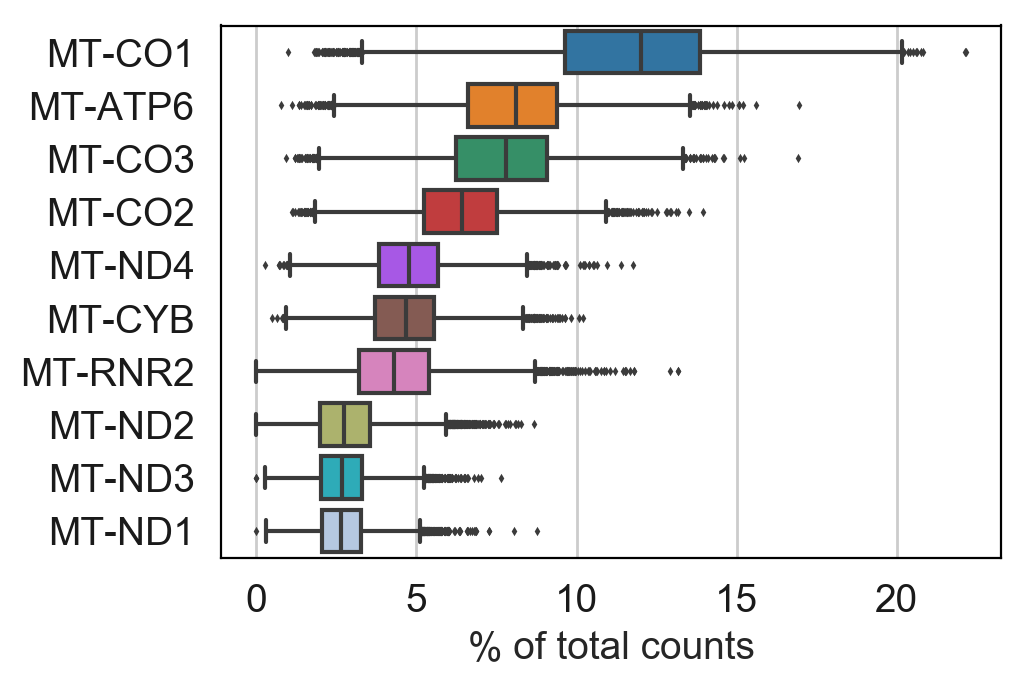

In [6]:
# look at highest expression by gene across all cells
sc.pl.highest_expr_genes(s1, n_top=10)

Looks like a lot of dead cells (high mitochondrial counts).  
Let's create some useful observations in our `AnnData` objects.

In [13]:
# get total counts for each observation (cell)
s1.obs['n_counts'] = s1.X.sum(axis=1) 

# get total number of genes detected for each observation (cell)
s1.obs['n_genes'] = s1.X.astype(bool).sum(axis=1)

# put cells in descending order based on total counts
descending_order = np.argsort(s1.obs['n_counts'])[::-1] 
s1.X = s1.X[descending_order,:].copy()
s1.obs = s1.obs.iloc[descending_order].copy()

# create new "observations" of percent mito reads per cell
mito_genes = s1.var_names.str.startswith('MT-') 
s1.obs['percent_mito'] = np.sum(s1[:, mito_genes].X, axis=1) / s1.obs['n_counts']

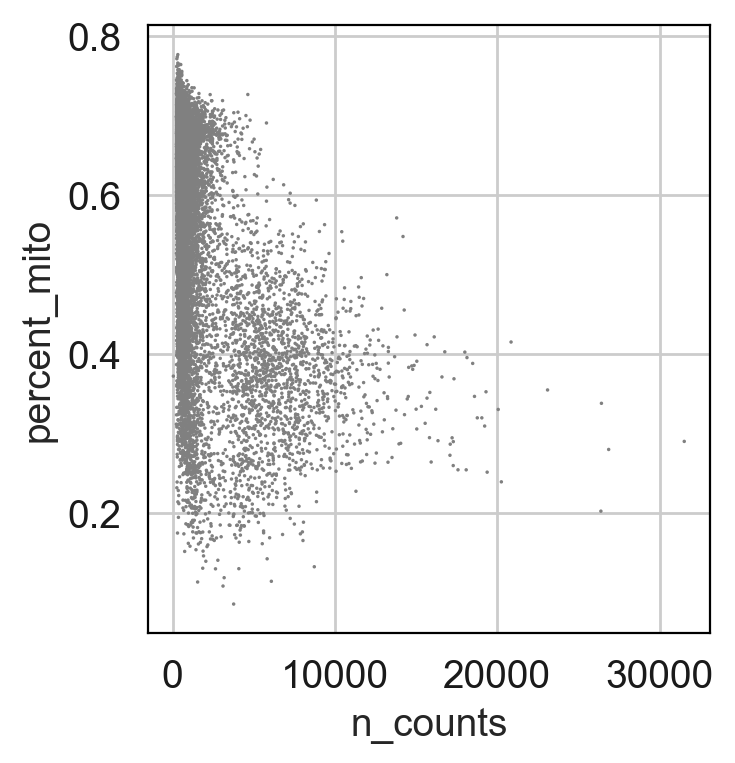

In [9]:
# look at low-quality and dead cell distribution
sc.pl.scatter(s1, x='n_counts', y='percent_mito')

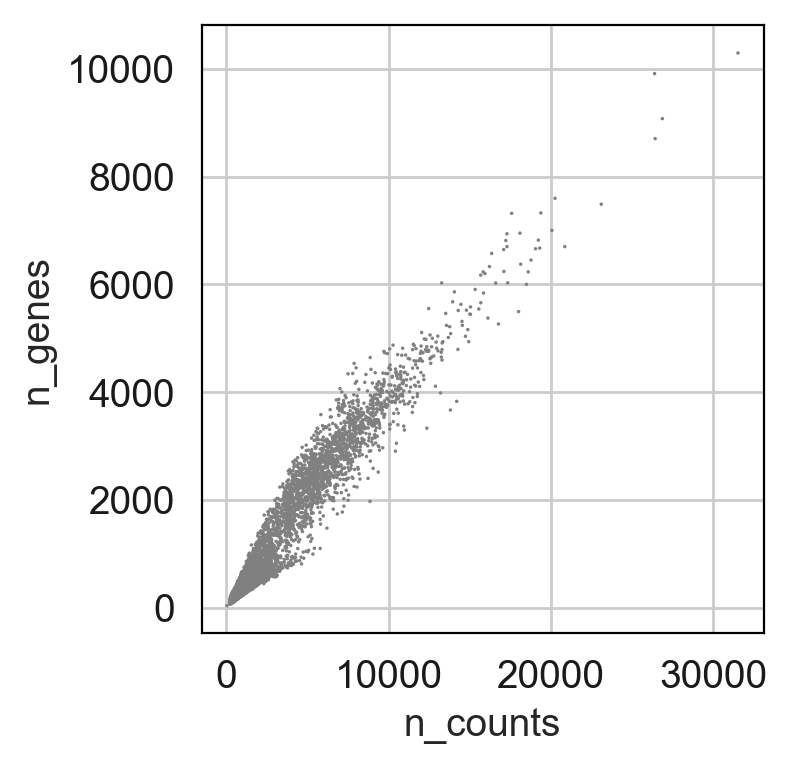

In [16]:
sc.pl.scatter(s1, x='n_counts', y='n_genes')

In [20]:
s1.raw = s1 # checkpoint before normalizing and scaling data

### Initialize find_inflection

In [17]:
def find_inflection(ann_data, inflection_percentiles = [0,15,30,100]):
    ann_data_cumsum = np.cumsum(ann_data.obs['n_counts'])
    x_vals=np.arange(0,ann_data.obs.shape[0])
    secant_coef=ann_data_cumsum[ann_data.obs.shape[0]-1]/ann_data.obs.shape[0]
    secant_line=secant_coef*x_vals
    secant_dist=abs(ann_data_cumsum-secant_line)
    inflection_percentiles_inds = np.percentile(x_vals,inflection_percentiles).astype(int)
    inflection_points = secant_dist.argsort()[::-1]
    percentile_points = inflection_points[inflection_percentiles_inds]
    color=plt.cm.tab10(np.linspace(0,1,ann_data.obs.shape[0]))
    plt.figure(figsize=(20,10))
    plt.plot(np.array(ann_data_cumsum), label="Cumulative Sum")
    plt.plot(np.array(secant_dist), label="Secant Distance")
    for percentile in percentile_points:
        plt.axvline(x=percentile,ymin=0,c=color[percentile],linestyle='--',linewidth=2,label="Inflection point {}".format(percentile))
    plt.legend()
    print("Inflection point at\n{}\nfor {} percentiles of greatest secant distances".format(percentile_points,inflection_percentiles))

### Find inflection point

Inflection point at
bcEGRW     3541
bcIJCL     2348
bcCQYE     7392
bcGZKI    10593
bcDZKU    19127
Name: n_counts, dtype: int64
for [0, 15, 30, 50, 100] percentiles of greatest secant distances


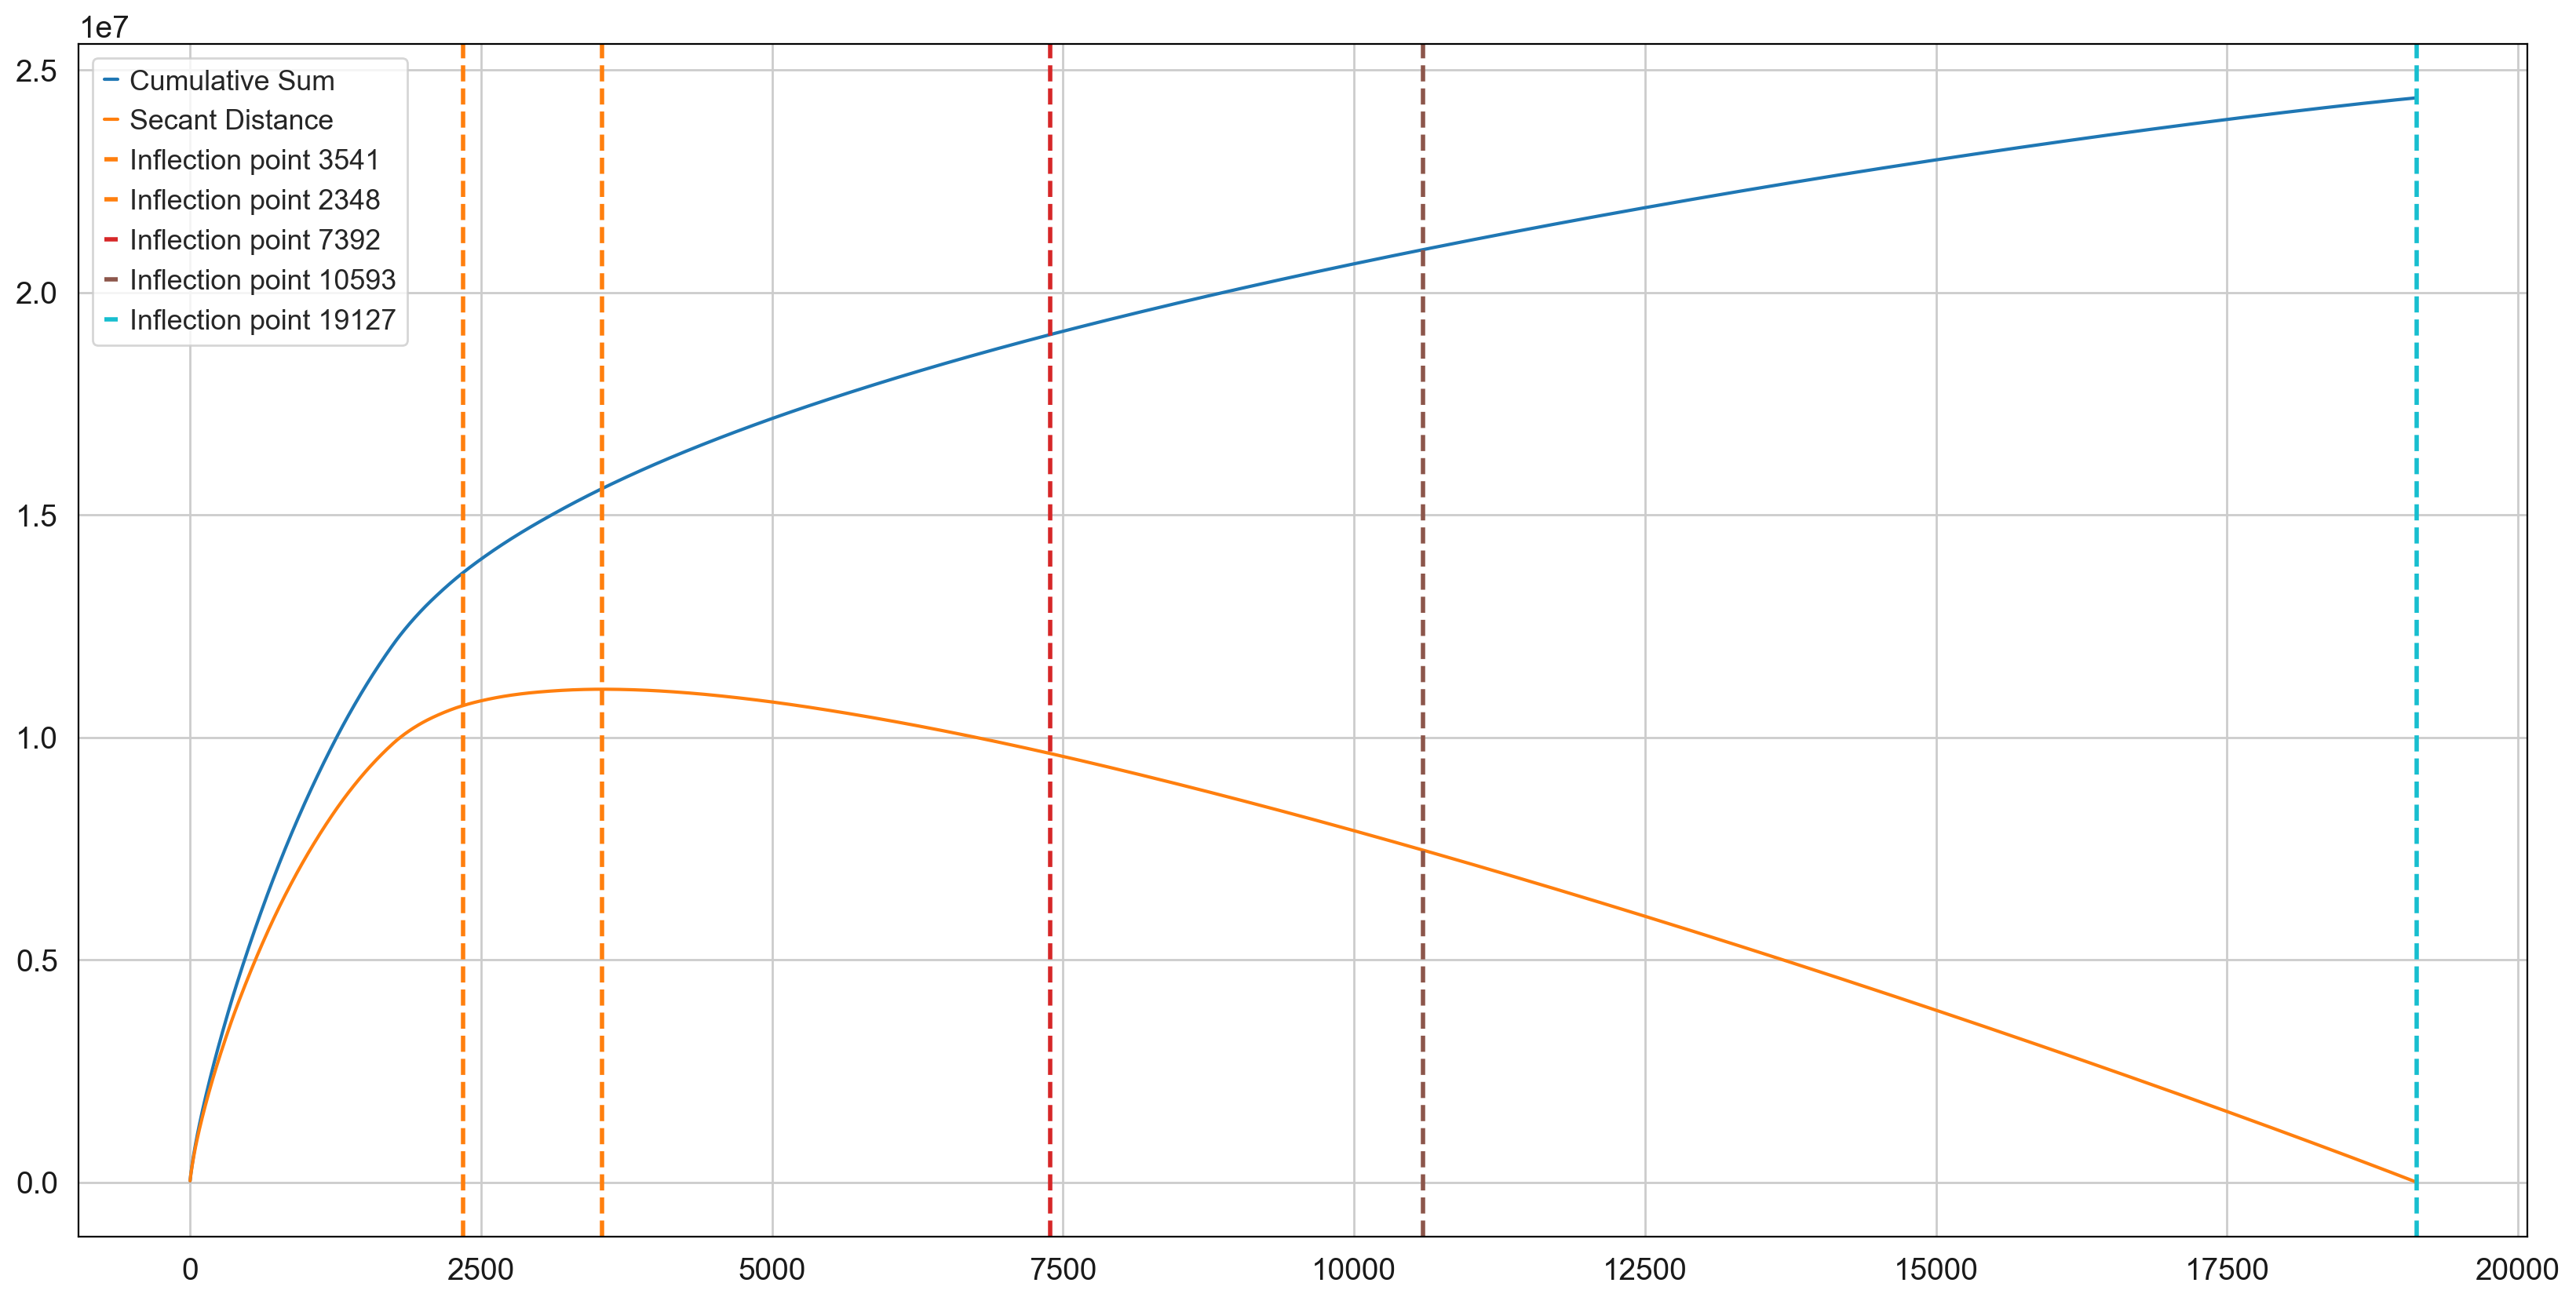

In [18]:
find_inflection(s1, inflection_percentiles = [0,15,30,50,100])

Let's not filter cells just yet - see how they cluster after dimensionality reduction

In [19]:
s1.obs['n_counts'][7392] # see the total counts for the cutoff point

682.0

In [22]:
s1.obs.tail

<bound method NDFrame.tail of         n_counts  percent_mito  n_genes
bcDZKU   31515.0      0.290528    10293
bcIBOG   26860.0      0.280380     9074
bcCYGU   26415.0      0.338406     8703
bcEDCF   26381.0      0.202835     9911
bcEONG   23097.0      0.355198     7486
...          ...           ...      ...
bcBPCX     237.0      0.312236      157
bcBKEL     235.0      0.727660       73
bcCAJR     229.0      0.646288       84
bcAFGG     229.0      0.698690       75
bcEGRW      51.0      0.372549       35

[19128 rows x 3 columns]>

Cutoff for `emptyDrops` should be at the number of counts above.   
Let's read in  `emptyDrops` predictions and filter out, then ID dead cells.

In [23]:
emptydrops = pd.read_csv('3247-AS-1-GCCAAT_S1_emptyDrops.csv')

In [24]:
emptydrops.index = emptydrops['barcode']

In [26]:
# create new "observation" as empty droplet label
s1.obs['empty'] = emptydrops['empty']

In [28]:
s1.obs['dead'] = np.where(s1.obs['percent_mito']>=0.5, 1, 0)

In [33]:
s1.obs['live'] = np.where((s1.obs['empty']==0) & (s1.obs['dead']==0), 1, 0)

In [43]:
s1.obs['label'] = np.where(s1.obs['live']==1, 'alive', 'dead')
s1.obs.loc[s1.obs['empty']==1,'label'] = 'empty'

In [55]:
# do some filtering using the metadata above
#s1 = s1[s1.obs['empty'] == 0, :]

### Normalize and perform linear dimensionality reduction with PCA

In [59]:
%%time
sc.pp.normalize_total(s1) #each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) #log1p normalization
sc.pp.scale(s1) #scaling by variance and centering to zero for visualization
sc.tl.pca(s1) #performing PCA

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


CPU times: user 22.1 s, sys: 1.8 s, total: 23.9 s
Wall time: 4.3 s


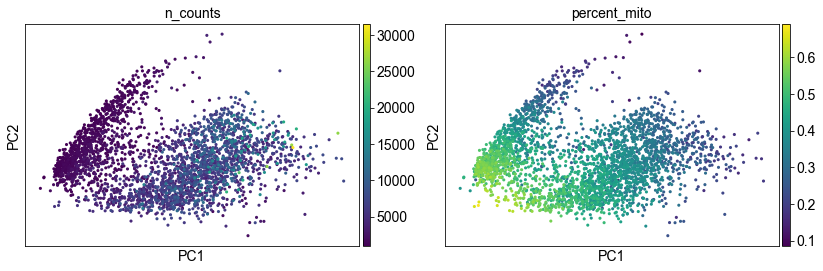

In [60]:
sc.pl.pca(s1, color=['n_counts','percent_mito'])

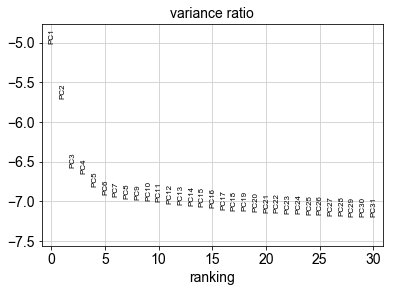

In [61]:
sc.pl.pca_variance_ratio(s1, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [62]:
sc.pp.neighbors(s1, n_neighbors=30, n_pcs=30) #UMAP requires this neighborhood calculation first, will give deprecation warnings

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:7

In [63]:
sc.tl.umap(s1) #perform UMAP

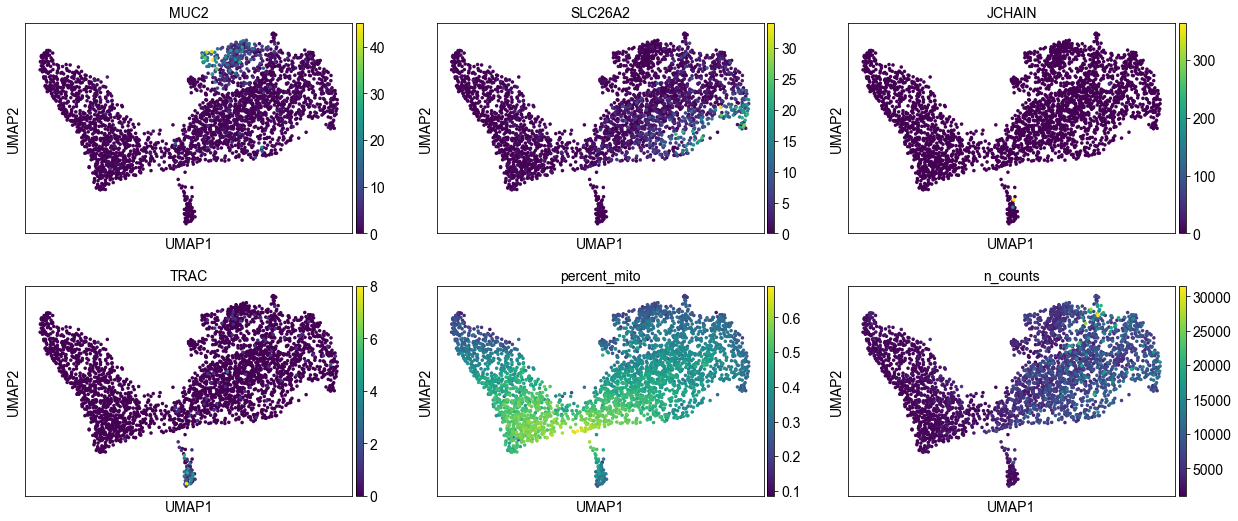

In [69]:
sc.pl.umap(s1, color=['MUC2','SLC26A2','JCHAIN','TRAC','percent_mito','n_counts'], ncols=3, size=50) #plot marker genes to determine which clusters to keep or gate out

### Clustering and gating

In [65]:
sc.tl.louvain(s1,resolution=1.2) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

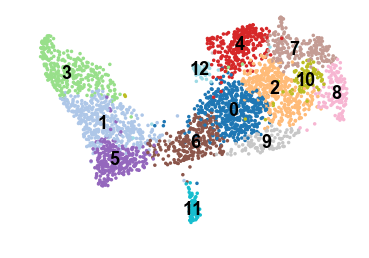

In [72]:
sc.pl.umap(s1, color=['louvain'], wspace=0.5, palette='tab20', legend_loc='on data', legend_fontsize=18, frameon=False, title='', size=50)

In [73]:
np.where(s1.obs['louvain'] == '6')[0]

array([  53,  175,  182,  256,  259,  264,  309,  341,  361,  404,  412,
        442,  468,  475,  508,  549,  556,  567,  578,  587,  590,  595,
        619,  621,  624,  628,  645,  660,  710,  715,  729,  752,  753,
        757,  772,  775,  785,  814,  815,  826,  876,  888,  910,  915,
        924,  935,  945,  975,  980,  987,  989,  990,  998, 1001, 1002,
       1003, 1029, 1037, 1042, 1051, 1052, 1064, 1080, 1111, 1145, 1148,
       1155, 1158, 1162, 1163, 1164, 1167, 1177, 1179, 1185, 1188, 1194,
       1196, 1205, 1206, 1207, 1212, 1213, 1230, 1249, 1256, 1257, 1270,
       1273, 1283, 1287, 1305, 1310, 1313, 1317, 1319, 1322, 1323, 1345,
       1349, 1350, 1368, 1373, 1385, 1409, 1411, 1419, 1425, 1431, 1434,
       1442, 1459, 1460, 1468, 1490, 1510, 1527, 1535, 1536, 1540, 1552,
       1564, 1569, 1573, 1578, 1582, 1584, 1587, 1588, 1591, 1595, 1597,
       1598, 1600, 1609, 1614, 1616, 1618, 1630, 1641, 1647, 1652, 1659,
       1665, 1666, 1671, 1673, 1678, 1684, 1686, 16

In [42]:
hi_mito = np.where(s1.obs['louvain'] == '6')[0]
s1_hi_mito = sc.AnnData(s1.raw.X[hi_mito,:])
s1_hi_mito.obs = s1.obs.iloc[hi_mito,:] #subsetting the original data to make a filtered dataset
s1_hi_mito.var = s1.var #transferring variable/feature names 

In [43]:
s1_hi_mito #quick check of reduced/filtered dataset properties

AnnData object with n_obs × n_vars = 13132 × 41569 
    obs: 'n_counts', 'percent_mito', 'louvain'

In [46]:
s1.n_obs - s1_hi_mito.n_obs

5996

So, based on the number of 'dead' cells from my UMAP above, there should be about 6k live ones. Filtering to 30% of the first inflection point would have given us ~7400 cells, which is conservative.  
Let's do that and then see the cluster of dead cells that are left.

In [57]:
sc.pp.filter_cells(s1, min_counts=s1.obs.iloc[7392].n_counts) # filter to 30% of secant inflection as determined above

In [58]:
s1.shape

(7399, 41569)

In [59]:
%%time
sc.pp.normalize_total(s1) #each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) #log1p normalization
sc.pp.scale(s1) #scaling by variance and centering to zero for visualization
sc.tl.pca(s1) #performing PCA

CPU times: user 42.2 s, sys: 2.72 s, total: 44.9 s
Wall time: 9.42 s


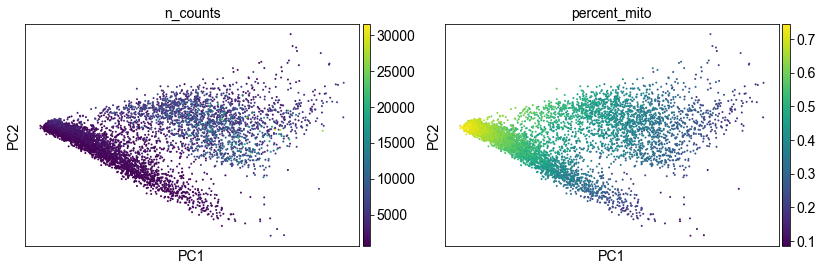

In [60]:
sc.pl.pca(s1, color=['n_counts','percent_mito'])

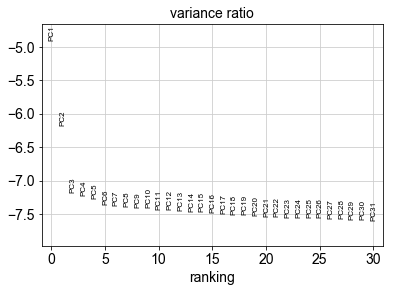

In [61]:
sc.pl.pca_variance_ratio(s1, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [62]:
sc.pp.neighbors(s1, n_neighbors=30, n_pcs=30) #UMAP requires this neighborhood calculation first, will give deprecation warnings

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:7

In [63]:
sc.tl.umap(s1) #perform UMAP

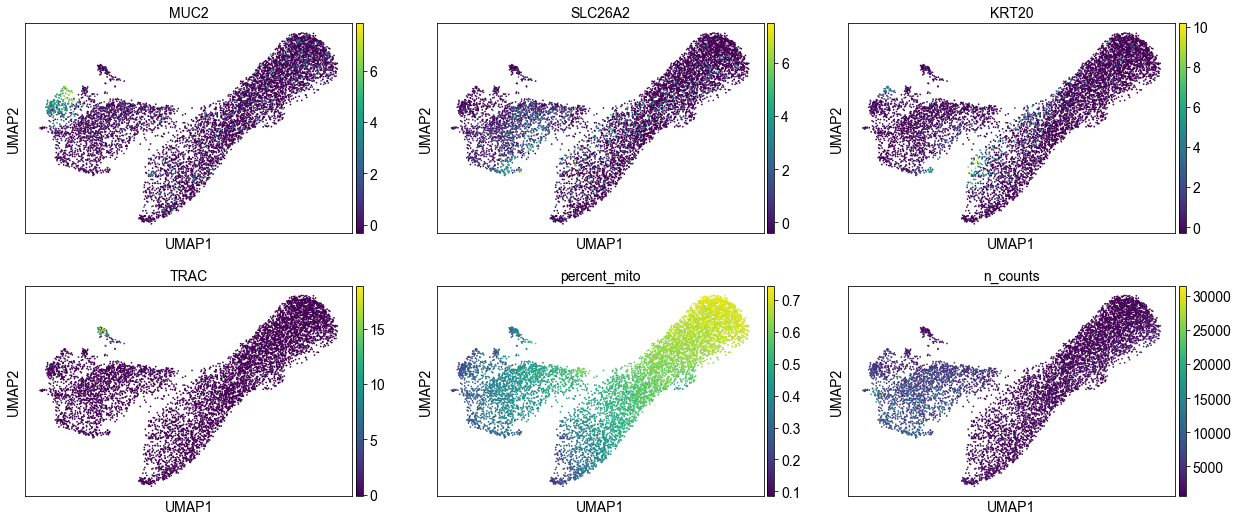

In [67]:
sc.pl.umap(s1, color=['MUC2','SLC26A2','KRT20','TRAC','percent_mito','n_counts'], ncols=3, size=12) #plot marker genes to determine which clusters to keep or gate out

### Clustering and gating

In [65]:
sc.tl.louvain(s1,resolution=1.2) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

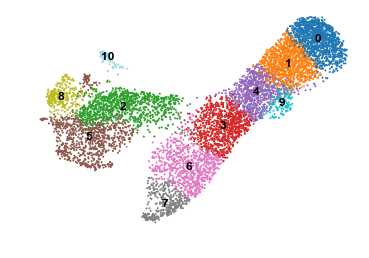

In [66]:
sc.pl.umap(s1, color=['louvain'], wspace=0.5, palette='tab20', legend_loc='on data', legend_fontsize=12, frameon=False, title='')

In [72]:
live = np.where(~s1.obs['louvain'].isin(['0','1','3','4','9']))[0]

In [83]:
s1[live,:].X.shape

(3294, 41569)

In [90]:
labels = np.zeros(s1.shape[0])
np.put(a=labels, ind=live, v=1)

In [93]:
# create new "observation" as dead or alive label
s1.obs['alive'] = labels

In [94]:
s1

AnnData object with n_obs × n_vars = 19128 × 41569 
    obs: 'n_counts', 'percent_mito', 'alive'

In [97]:
s1.obs['alive']

bcDZKU    1.0
bcIBOG    1.0
bcCYGU    1.0
bcEDCF    1.0
bcEONG    1.0
         ... 
bcBPCX    0.0
bcBKEL    0.0
bcCAJR    0.0
bcAFGG    0.0
bcEGRW    0.0
Name: alive, Length: 19128, dtype: float64

In [47]:
%%time
sc.pp.normalize_total(s1) #each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) #log1p normalization
sc.pp.scale(s1) #scaling by variance and centering to zero for visualization
sc.tl.pca(s1, n_comps=100) #performing PCA

CPU times: user 1min 54s, sys: 6.77 s, total: 2min 1s
Wall time: 28 s


In [48]:
s1.obsm['X_pca'].shape

(19128, 100)

---
### Machine Learning Classifiers

Test using wrapper function from `ml_utils.py`

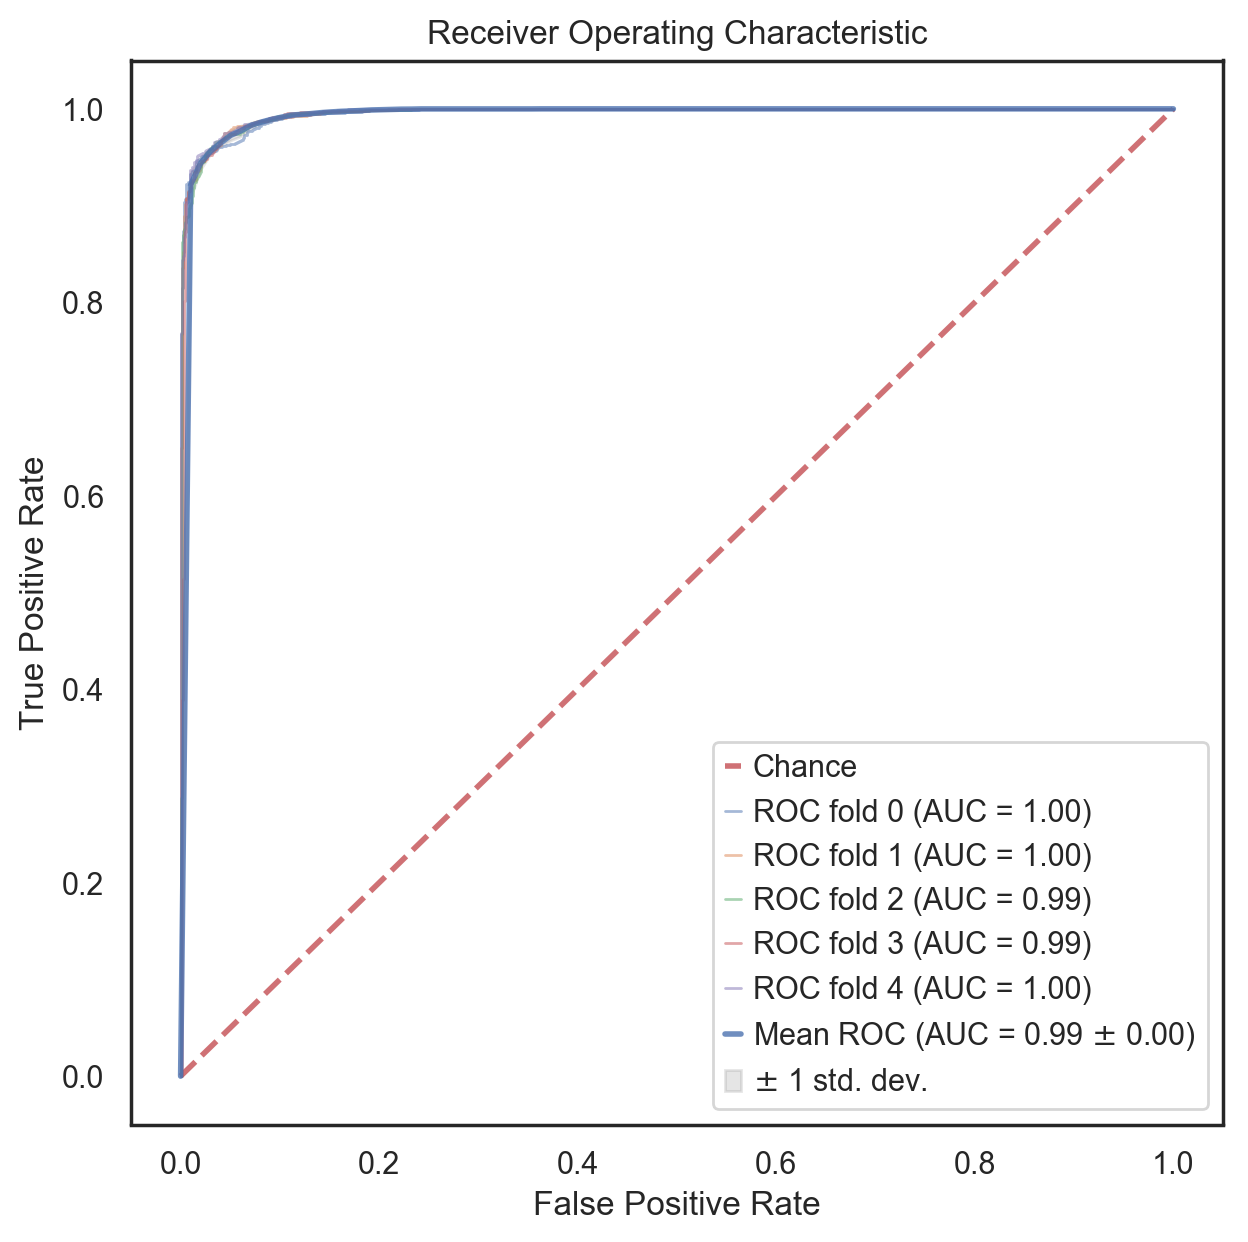

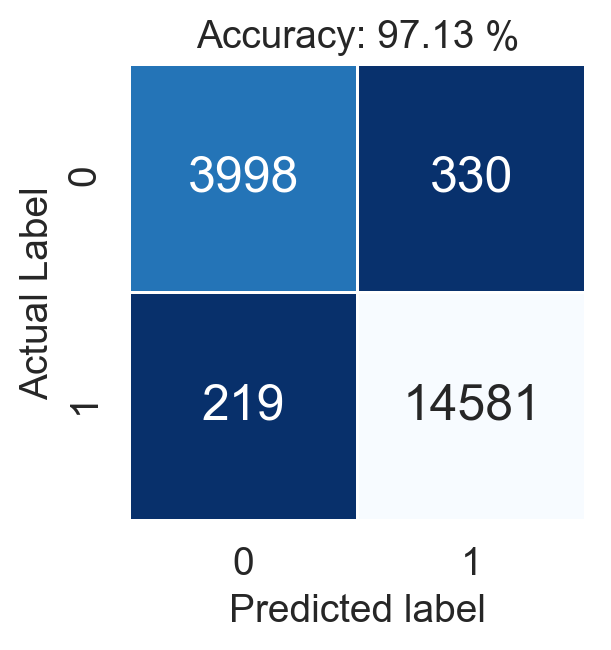

CPU times: user 1min 25s, sys: 6.89 s, total: 1min 32s
Wall time: 16 s


In [57]:
%%time
# Logistic Regression Classifier
lr = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial', max_iter=1000)
mets = roc_kfold(clf=lr, X=s1.obsm['X_pca'], y=s1.obs['dead'], k=5, seed=18)

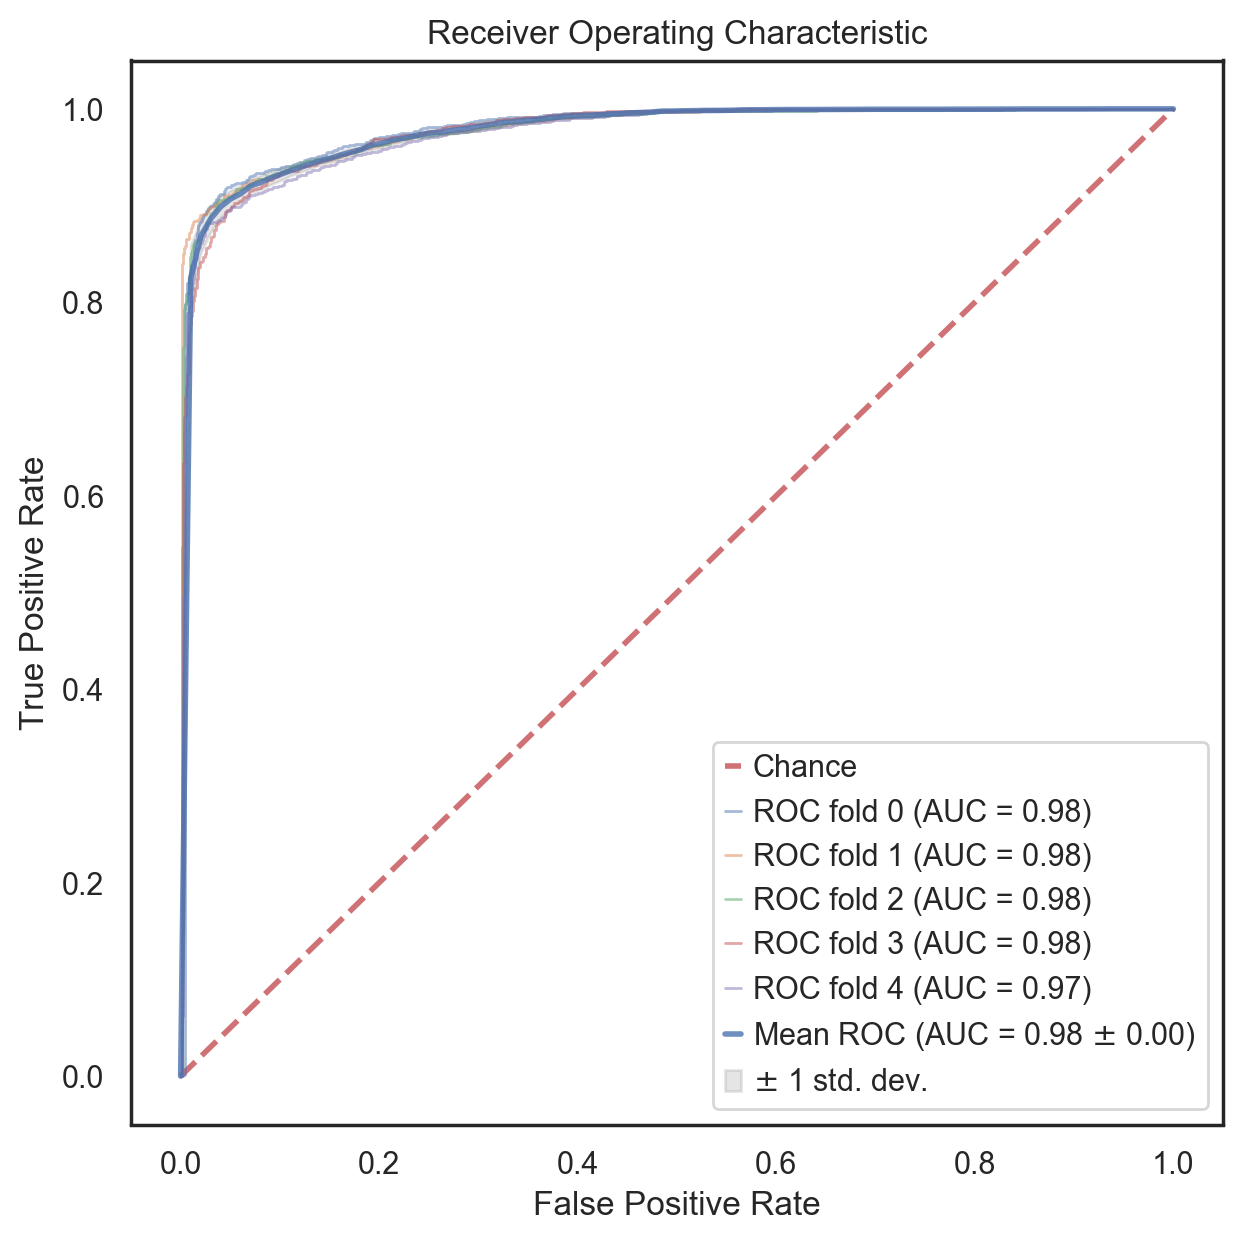

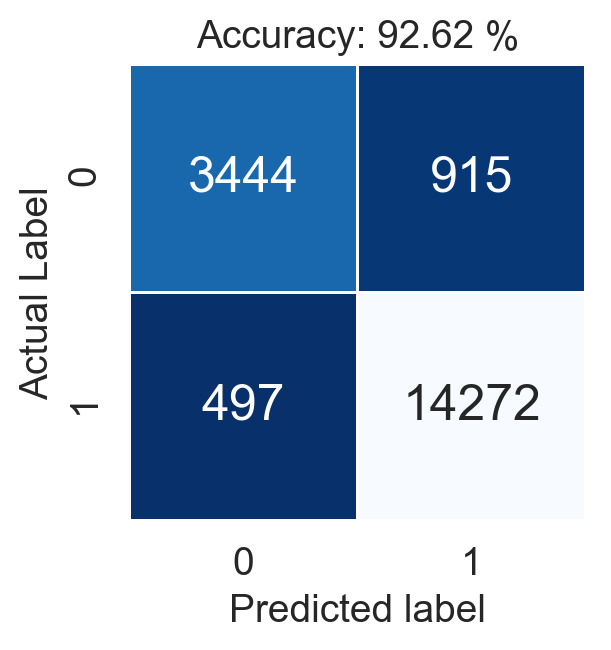

CPU times: user 1min 1s, sys: 5.04 s, total: 1min 6s
Wall time: 11.7 s


In [58]:
%%time
# Logistic Regression Classifier
lr = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial', max_iter=1000)
mets = roc_kfold(clf=lr, X=s1.obsm['X_pca'], y=s1.obs['empty'], k=5, seed=18)

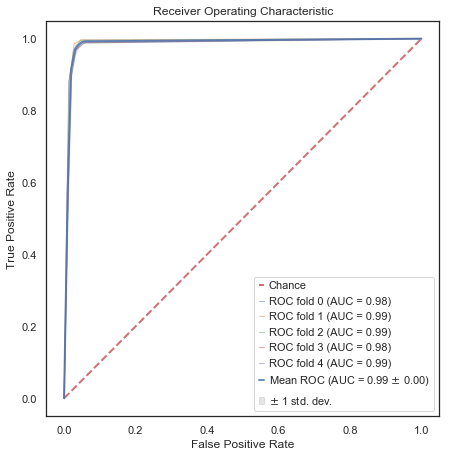

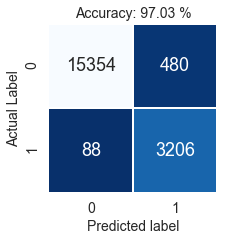

In [137]:
# K-Nearest Neighbors Classifier
kn = KNeighborsClassifier(n_neighbors=3)
mets = roc_kfold(clf=kn, X=s1.obsm['X_pca'], y=s1.obs['alive'], k=5, seed=18)

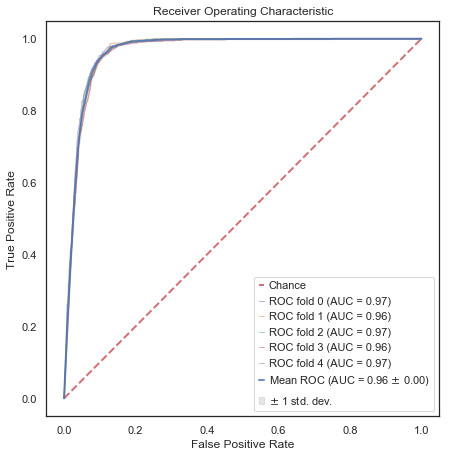

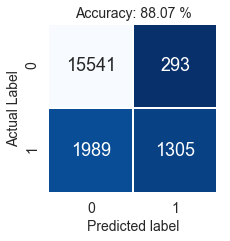

In [138]:
# Gaussian Naive Bayes Classifier
gnb = GaussianNB()
mets = roc_kfold(clf=gnb, X=s1.obsm['X_pca'], y=s1.obs['alive'], k=5, seed=18)

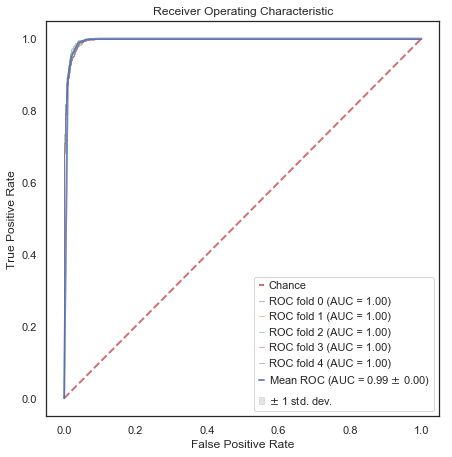

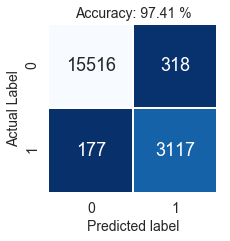

In [139]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
mets = roc_kfold(clf=gbc, X=s1.obsm['X_pca'], y=s1.obs['alive'], k=5, seed=18)

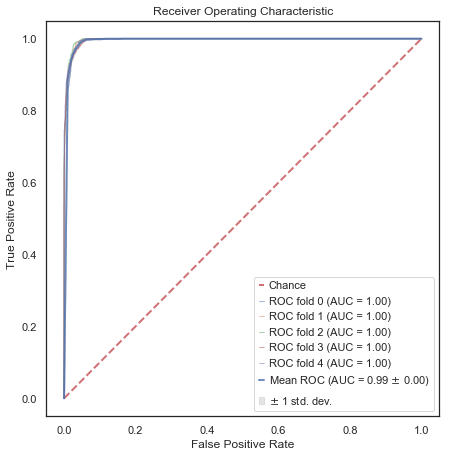

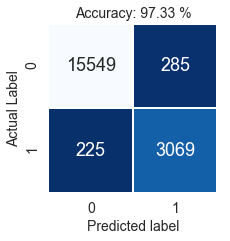

In [140]:
# AdaBoost Classifier
abc = AdaBoostClassifier()
mets = roc_kfold(clf=abc, X=s1.obsm['X_pca'], y=s1.obs['alive'], k=5, seed=18)

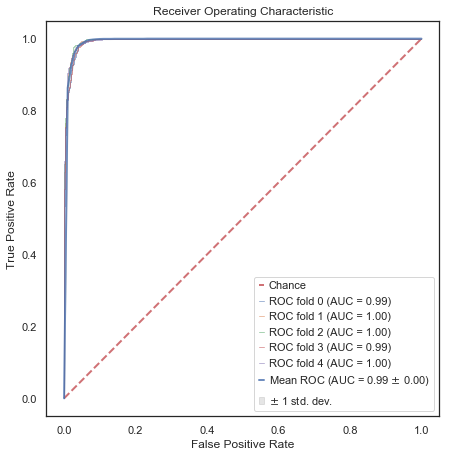

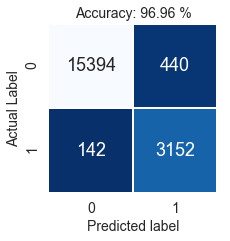

In [141]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=0)
mets = roc_kfold(clf=rf, X=s1.obsm['X_pca'], y=s1.obs['alive'], k=5, seed=18)

---

So it looks like the __Gradient Boosting Classifier__ is our best bet based on AUROC and Accuracy values.  
Now, we can optimize the hyperparameters using `RandomizedSearchCV` to tweak the classifier for the best result and compare optimized classifier.

In [145]:
from pprint import pprint

In [146]:
# Generate grid of hyperparameters to test
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
loss = ['deviance', 'exponential']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# learning rate
learning_rate = np.linspace(0.1, 1, 10)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'loss': loss,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}
pprint(random_grid)

{'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'loss': ['deviance', 'exponential'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [147]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbc = GradientBoostingClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=18, n_jobs = -1)
# Fit the random search model
gbc_random.fit(s1.obsm['X_pca'], s1.obs['alive'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.2s
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.3min finished


CPU times: user 26.2 s, sys: 980 ms, total: 27.2 s
Wall time: 12min 37s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [148]:
gbc_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 70,
 'loss': 'exponential',
 'learning_rate': 0.30000000000000004}

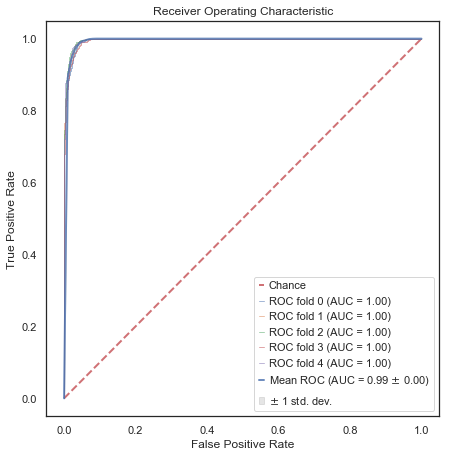

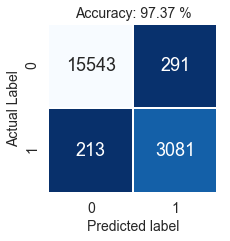

In [149]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features='auto', max_depth=70, loss='exponential', learning_rate=0.3)
mets = roc_kfold(clf=gbc, X=s1.obsm['X_pca'], y=s1.obs['alive'], k=5, seed=18)